## Units heatmaps

Plot a few heatmaps for some M2 units

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

import sys
sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from analysis.ephys.utils import get_recording_names

glm_cache = Path(
    r"D:\GLM\data"
)



In [137]:
TARGET = "MOs"
# recordings = get_recording_names(region=TARGET)

rec = "FC_220415_BAA1101192_hairpin"  # 33, 34, 35

_data = pd.read_hdf(glm_cache / f"{rec}_bouts.h5")
_tracking = pd.read_hdf(glm_cache / f"{rec}_bouts_xy.h5")

In [138]:
variables = ("v", "v_squared", "dv_300ms", "omega", "domega_300ms", "omega_squared", "apex_distance")
units = [c for c in _data.columns if c not in variables and "shuffle" not in c]

mins_speed = 0

data_reverse = _data.loc[(_tracking.ds > -300)&(_tracking.ds < 0)&(_data.v > mins_speed)][units]
data = _data.loc[(_tracking.ds > 0)&(_tracking.ds < 300)&(_data.v > mins_speed)][units]
tracking_reverse = _tracking.loc[(_tracking.ds > -300)&(_tracking.ds < 0)&(_data.v > mins_speed)]
tracking = _tracking.loc[(_tracking.ds > 0)&(_tracking.ds < 300)&(_data.v > mins_speed)]

In [139]:
# sort units by the average firing rate
firing_rates = data.max()
firing_rates = firing_rates.sort_values(ascending=False)
firing_rates

mean_firing_rates = data.mean()
mean_firing_rates = mean_firing_rates.sort_values(ascending=False)

<Figure size 1440x2160 with 54 Axes>

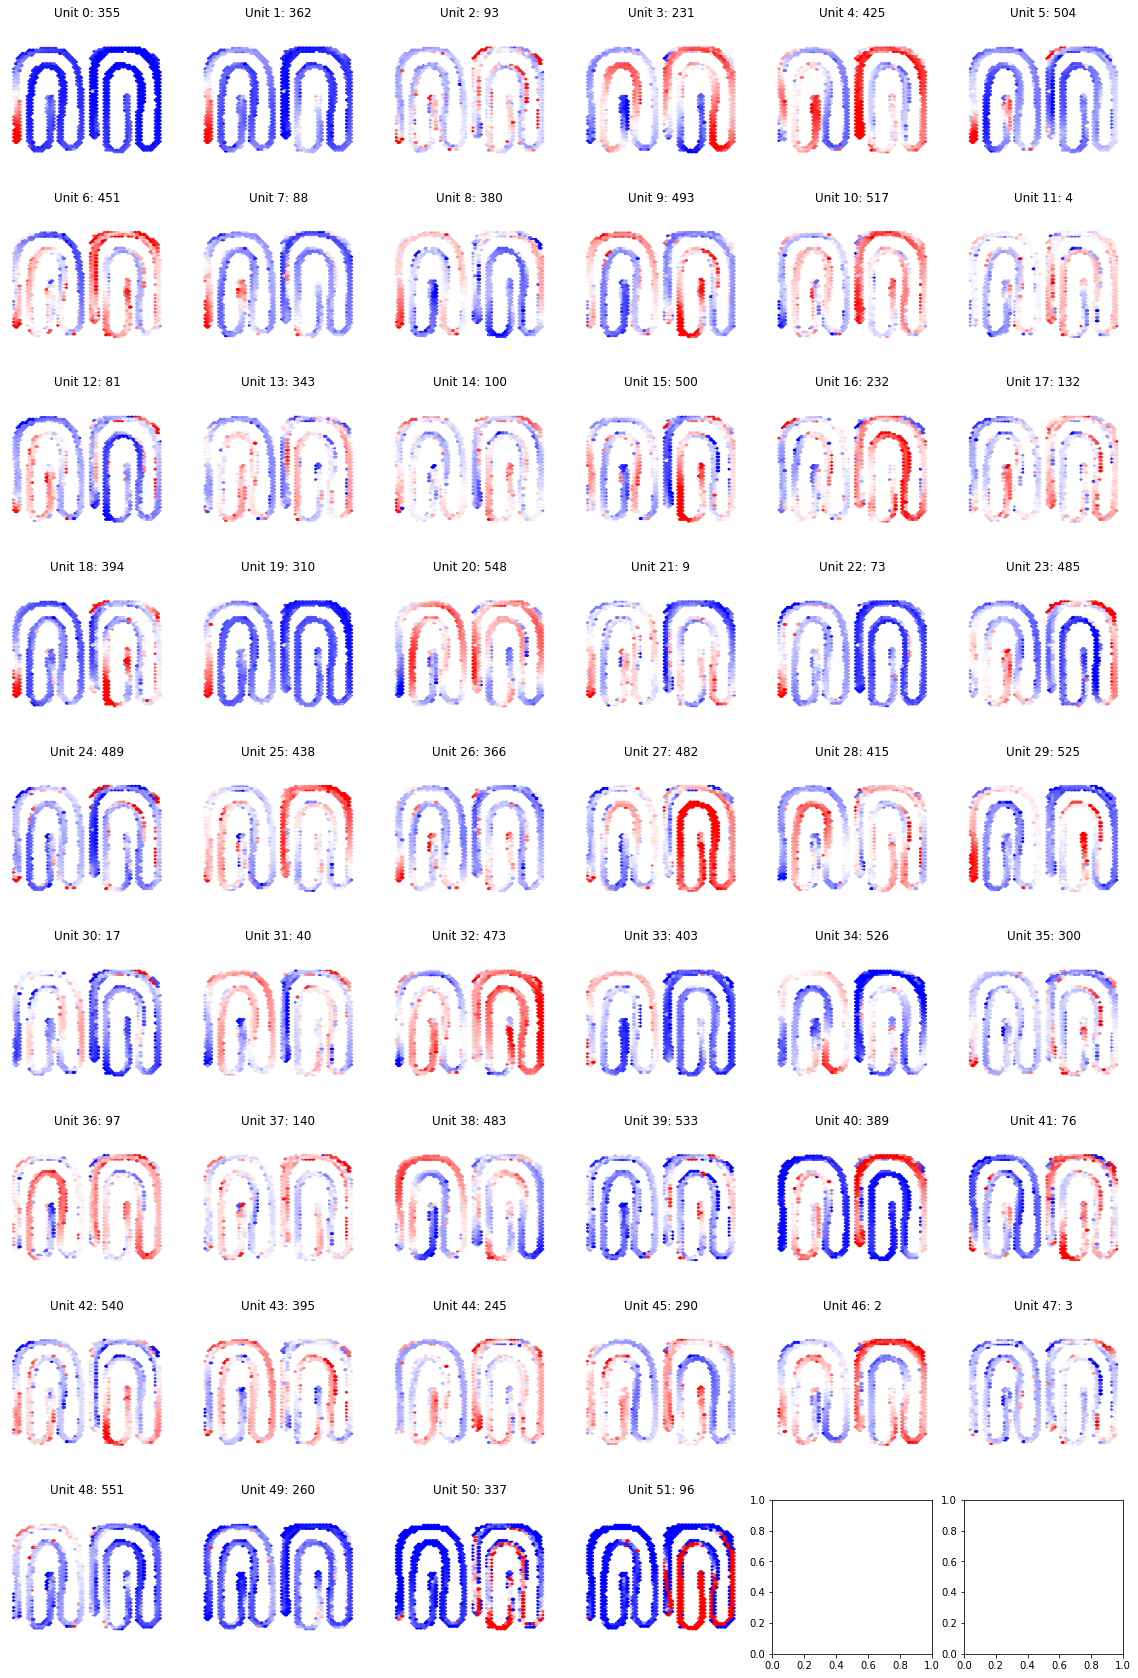

In [140]:
# plot hexbin of XY coordinates and a unit's firing rate
from fcutils.plot.figure import calc_nrows_ncols

nrows, ncols = calc_nrows_ncols(len(units), aspect=(1, 1.5))

f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
axes = axes.flatten()[:len(units)]

for unit_id, ax in enumerate(axes):
    unit = firing_rates.index[unit_id]
    unit_fr = data[unit]
    # clip firing rate to 99th percentile
    unit_fr = unit_fr.clip(upper=np.percentile(unit_fr, 95))
    unit_fr_reversed = data_reverse[unit]

    ax.axis("equal")
    ax.set(title= f"Unit {unit_id}: {unit}")
    ax.axis("off")
    ax.hexbin(tracking.x, tracking.y, unit_fr, gridsize=[20, 30],   cmap="bwr", mincnt=10, vmin=np.percentile(unit_fr, 5), vmax=np.percentile(unit_fr, 96))
    ax.hexbin(tracking_reverse.x + 41, tracking_reverse.y, unit_fr_reversed, gridsize=[20, 30],   cmap="bwr", mincnt=10, vmin=np.percentile(unit_fr, 5), vmax=np.percentile(unit_fr, 96))

## Plot selected units
with more details

In [141]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(ax, im, cbar_label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="15%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(cbar_label)
    return cbar


<Figure size 576x864 with 2 Axes>

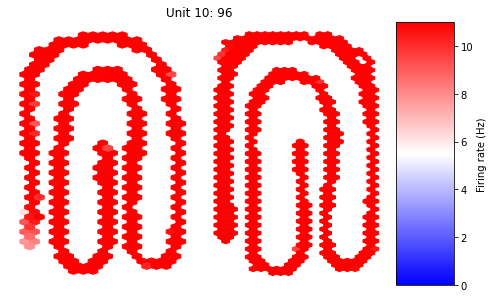

In [142]:
selected_units = [
    # (9, 2, 11),
    (10, 0, 11),
]

for unit_id, min_fr, max_fr in selected_units:
    unit_num = firing_rates.index[unit_id]
    unit_fr = data[unit_num]
    unit_fr_reversed = data_reverse[unit_num]

    
    # unit_fr = unit_fr.clip(upper=np.percentile(unit_fr, 95))
    f, ax = plt.subplots(figsize=(8, 12))
    ax.axis("equal")
    ax.set(title= f"Unit {unit_id}: {unit}")
    ax.axis("off")
    im = ax.hexbin(tracking.x, tracking.y, unit_fr, gridsize=[16, 24],   cmap="bwr", mincnt=25, vmin=min_fr, vmax=max_fr)
    ax.hexbin(tracking_reverse.x + 45, tracking_reverse.y, unit_fr_reversed, gridsize=[20, 30],   cmap="bwr", mincnt=25, vmin=min_fr, vmax=max_fr)
    add_colorbar(ax, im, "Firing rate (Hz)")

    
    # save figure
    # f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\activity_heatmaps_{rec}_unit_{unit_num}.svg", dpi=300)
    break

## Plot tuning curves

In [143]:
_bins = pd.cut(_data.v, bins=np.arange(0, 100, 5))
groups = _data.groupby(_bins)
mu = groups.mean()
sigma = groups.std()
counts = groups.count().v

mu = mu.dropna()
sigma = sigma.dropna()
mu = mu.loc[counts > 5000]
sigma = sigma.loc[counts > 5000]

bin_values = [b.mid if isinstance(b, pd.Interval) else np.nan for b in mu.index]

<Figure size 1152x648 with 1 Axes>

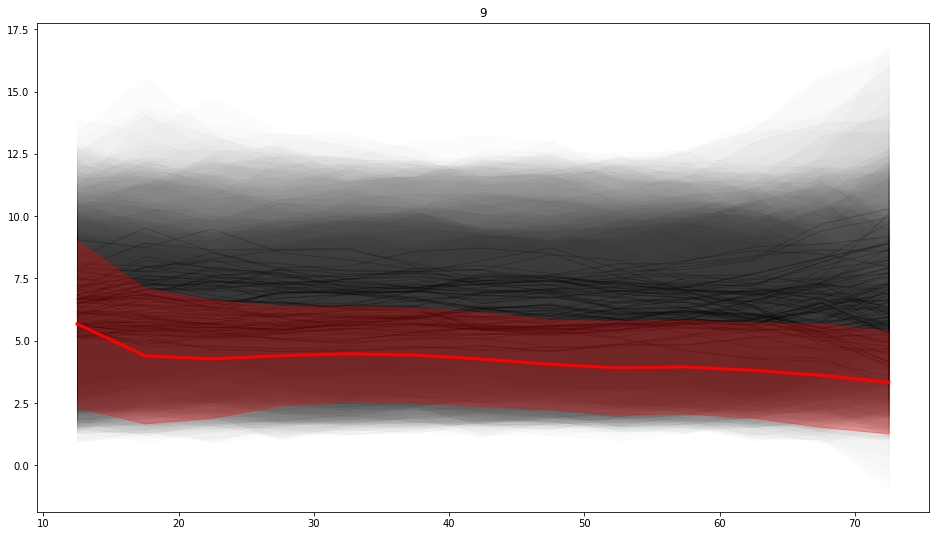

In [144]:
from fcutils.plot.elements import plot_mean_and_error

idx = 47
f, ax = plt.subplots(figsize=(16, 9))
ax.set(title=units[idx])
plot_mean_and_error(
    mu[units[idx]], sigma[units[idx]], ax=ax, color="red", x=bin_values
)
# plt.plot(bin_values, mu[units[idx]].values, lw=2, color="red")

for i in range(100):
    # plt.plot(
    #     bin_values, mu[units[idx]+f"_shuffle_{i}"].values, lw=0.5, color="k", zorder=-1, alpha=0.1
    # )
    
    plot_mean_and_error(
        mu[units[idx]+f"_shuffle_{i}"], sigma[units[idx]+f"_shuffle_{i}"], ax=ax, err_alpha=.01, alpha=.2, lw=1, color="k", zorder=-1, x=bin_values
    )